코드 블로그: https://tyami.github.io/deep%20learning/GAN-2-implementation-GAN/

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
print('numpy: ' + np.__version__)
print('pandas: ' + pd.__version__)
print('matplotlib: ' + matplotlib.__version__)
print('numpy: ' + torch.__version__)
print('numpy: ' + torchvision.__version__)

numpy: 1.22.4
pandas: 1.5.3
matplotlib: 3.7.1
numpy: 2.0.1+cu118
numpy: 0.15.2+cu118


결과 재현을 위한 Random seed

In [ ]:
import random

manualSeed = 1
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else 'cpu')

print(device)

cuda


MNIST 데이터 다운

In [ ]:
batch_size = 64

standardizer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 1)
])

train_data = datasets.MNIST(root='../data/', train=True, transform=standardizer, download = True)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)

잘 불러와 지는지 이미지 시각화

In [ ]:
def tc_imshow(img, lbl=""):
  if img.size(0) == 1:
    plt.imshow(img.squeeze(), cmap='gray')
  else:
    plt.imshow(np.transpose(img, (1,2,0)))

  plt.title(lbl)
  plt.axis('off')

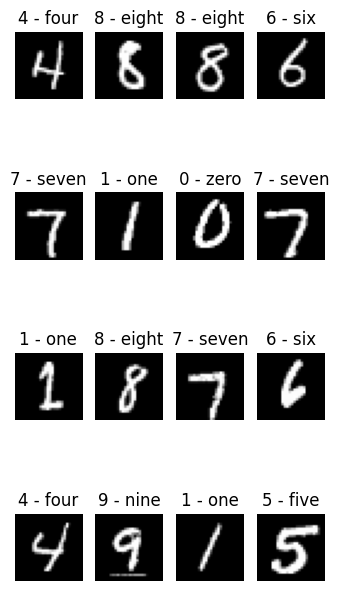

In [ ]:
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  tc_imshow(img=mini_batch_img[i],
            lbl=train_data.classes[mini_batch_lbl[i].numpy()]
            )

랜덤 노이즈를 샘플링할 분포 정의

In [ ]:
dim_noise = 100

def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.randn(batch_size, dim_noise, device=device)

Generative model 정의

In [ ]:
dim_hidden = 256
sz_output = 28
num_channels = 1

dim_output = sz_output**2
img_shape = (num_channels, sz_output, sz_output)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(dim_noise, dim_hidden),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_hidden),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_output),
        nn.Tanh()
    )
  def forward(self,z):
    img = self.model(z)
    img = img.view(img.size(0), *img_shape) # 아마 (batch_size, color, width, height) 순의 shape일듯
#    img_for_print = img.view(*img_shape)     만약 이미지 보고싶으면 이 주석 풀어서 보면 됨
    return img#, img_for_print


랜덤 노이즈 -> 생성 모델로부터 나온 데이터

In [ ]:
G = Generator()
z = random_sample_z_space()
z.to(device)
G.to(device)
img = G(z)
utils.save_image(img[:25].cpu().detach(), "./2-G(z).png", nrow=5, normalize=True)
# plt.imshow(np.transpose(img_for_print.cpu().detach(),(1,2,0)), cmap='gray')  # 이미지 보고싶으면 이 주석 풀어서 보면 됨

- 아직 Generator의 학습이 되지 않아서, 노이즈로부터 Generator로 매핑을 해도 의미없는 output이 나온다.

## Discriminative model D

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(dim_output, dim_hidden), # generator의 output을 받아서 discriminate를 하는 것이기 때문에 Linear의 처음 input shape가 dim_output이다.
        nn.LeakyReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_hidden),
        nn.LeakyReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden,1),
        nn.Sigmoid()
    )

  def forward(self, img):
    flat_img = img.view(img.size(0),-1) # 원래 (batch_size, color, width, height) 였는데, 여기서 color는 1이라 없는 셈 치면 width,height를 그냥 linear로 합친 꼴
    check_validity = self.model(flat_img) # reshape 하고 model에 입력으로 넣는거

    return check_validity

## Generator와 Discriminator 학습

#### 6.1 모델 선언

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

#### 6.2 Loss function 과 Optimizer 선언

In [ ]:
lr = 0.0002
beta1 = 0.9 # beta는 Adam의 설정인데, 해당 내용 파악 필요

In [ ]:
adversarial_loss = nn.BCELoss()

In [ ]:
optimizer_G = optim.Adam(generator.parameters(), lr = lr, betas = (beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, 0.999))


### 6.3 Train models

epoch과 어느 시점에 image를 save할지 지정 (여기서는 batch_size 1000마다 저장한다.)

In [ ]:
num_epochs = 200
interval_save_img = 1000

In [ ]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor # 데이터 타입 정의인듯.

In [ ]:
#Variable(Tensor(mini_batch_img.size(0), 1).fill_(1.0), requires_grad=False)
#Variable(imgs.type(Tensor))

##### Training 시작

In [ ]:
import os
os.getcwd()
os.makedirs("./result/GAN/1-GAN")

In [ ]:
losses = []

for idx_epoch in range(num_epochs):
  for idx_batch, (imgs, _) in enumerate(train_data_loader):
    real_ground_truth = Variable(Tensor(imgs.size(0),1).fill_(1.0), requires_grad=False) # 진짜 데이터는 label 1로 지정
    fake_ground_truth = Variable(Tensor(imgs.size(0),1).fill_(0.0), requires_grad=False) # 가짜로 생성한 데이터는 label 0으로 지정

    real_imgs = Variable(imgs.type(Tensor))

    optimizer_G.zero_grad()

    z = random_sample_z_space(imgs.size(0))

    gen_imgs = generator(z)
    
    loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)

    loss_G.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()
    loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
    loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
    loss_D = (loss_real + loss_fake)/2
    
    loss_D.backward()
    optimizer_D.step()


    losses.append([loss_G.item(), loss_D.item()])

    # Print progress
    if idx_batch % 10 == 0:
        print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs,
                                                                                  idx_batch, len(train_data_loader),
                                                                                  loss_G, loss_D))

    batches_done = idx_epoch * len(train_data_loader) + idx_batch
    if batches_done % interval_save_img == 0:
        utils.save_image(gen_imgs.data[:25], "./result/GAN/1-GAN/3-{}.png".format(batches_done), nrow=5, normalize=True)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 138/200] [Batch 560/938] loss_G: 2.710628, loss_D: 0.227972
[Epoch 138/200] [Batch 570/938] loss_G: 3.265527, loss_D: 0.232800
[Epoch 138/200] [Batch 580/938] loss_G: 3.032933, loss_D: 0.149995
[Epoch 138/200] [Batch 590/938] loss_G: 2.865847, loss_D: 0.198826
[Epoch 138/200] [Batch 600/938] loss_G: 3.007118, loss_D: 0.175332
[Epoch 138/200] [Batch 610/938] loss_G: 2.759622, loss_D: 0.183408
[Epoch 138/200] [Batch 620/938] loss_G: 3.403048, loss_D: 0.223142
[Epoch 138/200] [Batch 630/938] loss_G: 2.743292, loss_D: 0.298534
[Epoch 138/200] [Batch 640/938] loss_G: 2.812739, loss_D: 0.218135
[Epoch 138/200] [Batch 650/938] loss_G: 2.982703, loss_D: 0.175029
[Epoch 138/200] [Batch 660/938] loss_G: 3.030822, loss_D: 0.211547
[Epoch 138/200] [Batch 670/938] loss_G: 3.361161, loss_D: 0.180678
[Epoch 138/200] [Batch 680/938] loss_G: 2.914903, loss_D: 0.219517
[Epoch 138/200] [Batch 690/938] loss_G: 2.660020, loss_D: 0.271265
[Epoch 138/200] [Batch 700

KeyboardInterrupt: ignored

새롭게 알게된 점:
- loss function의 구현을 BCELoss로 하는 것, 실제 loss는 따로 명시를 안한다는 점